In [58]:
from robomaster import robot
import time
import threading
import copy
import pandas as pd

data_log = []
stop_event = threading.Event()
robot_graph = {
    'angle': 0,
    'tof': 0
}

def sub_data_handler(sub_info):
    # รับข้อมูลระยะทางจากเซ็นเซอร์ TOF
    robot_graph['tof'] = sub_info[0]+75

def sub_data_handler_angle(angle_info):
    # รับข้อมูลมุมจากกิมบอล
    pitch_angle, yaw_angle, pitch_ground_angle, yaw_ground_angle = angle_info
    print(f"gimbal angle: pitch_angle:{pitch_angle}, yaw_angle:{yaw_angle}, pitch_ground_angle:{pitch_ground_angle}, yaw_ground_angle:{yaw_ground_angle}")
    robot_graph['angle'] = yaw_angle

def data_logger(log_interval):
    """
    ฟังก์ชันนี้จะทำงานใน background thread
    เพื่อบันทึกสถานะของหุ่นยนต์ลง list ตามช่วงเวลาที่กำหนด
    """
    while not stop_event.is_set():
        # คัดลอกสถานะล่าสุดเพื่อป้องกันปัญหาข้อมูลเปลี่ยนขณะบันทึก
        current_log = copy.deepcopy(robot_graph)
        data_log.append(current_log)
        time.sleep(log_interval)
    print("Data logger thread stopped.")
#grimball to sensor 75
if __name__ == '__main__':
    ep_robot = robot.Robot()
    ep_robot.initialize(conn_type="ap")
    ep_gimbal = ep_robot.gimbal
    ep_sensor = ep_robot.sensor

    log_interval = 0.2
    logger_thread = threading.Thread(target=data_logger, args=(log_interval,))


    # หมุนกิมบอลไปที่ yaw=90 ด้วยความเร็ว 45 องศา/วินาที
    ep_gimbal.moveto(pitch=0, yaw=90, pitch_speed=45, yaw_speed=45).wait_for_completed()
    logger_thread.start()
    # สมัครรับข้อมูลระยะทางจากเซ็นเซอร์ TOF
    ep_sensor.sub_distance(freq=5, callback=sub_data_handler)
    # สมัครรับข้อมูลมุมจากกิมบอล
    ep_gimbal.sub_angle(freq=5, callback=sub_data_handler_angle)

    # หมุนกิมบอลไปที่ yaw=-90 ด้วยความเร็ว 45 องศา/วินาที
    ep_gimbal.moveto(pitch=0, yaw=-90, pitch_speed=45, yaw_speed=45).wait_for_completed()

    # หยุด data logger
    stop_event.set()
    logger_thread.join()

    ep_robot.close()

    df = pd.DataFrame(data_log)
    # จัดลำดับคอลัมน์ให้สวยงาม
    cols =[k for k in robot_graph.keys()]
    df = df[cols]
    df.to_csv("robot_full_data.csv", index=False)
    print("Data saved to robot_full_data.csv successfully.")

gimbal angle: pitch_angle:-2.4, yaw_angle:82.8, pitch_ground_angle:0.0, yaw_ground_angle:90.7
gimbal angle: pitch_angle:-2.4, yaw_angle:74.1, pitch_ground_angle:0.0, yaw_ground_angle:81.7
gimbal angle: pitch_angle:-2.3, yaw_angle:64.8, pitch_ground_angle:0.0, yaw_ground_angle:72.7
gimbal angle: pitch_angle:-2.2, yaw_angle:55.6, pitch_ground_angle:0.0, yaw_ground_angle:63.7
gimbal angle: pitch_angle:-2.1, yaw_angle:46.9, pitch_ground_angle:0.0, yaw_ground_angle:54.7
gimbal angle: pitch_angle:-1.9, yaw_angle:38.0, pitch_ground_angle:0.0, yaw_ground_angle:45.7
gimbal angle: pitch_angle:-1.7, yaw_angle:28.8, pitch_ground_angle:0.0, yaw_ground_angle:36.7
gimbal angle: pitch_angle:-1.5, yaw_angle:18.9, pitch_ground_angle:0.0, yaw_ground_angle:26.8
gimbal angle: pitch_angle:-1.3, yaw_angle:9.7, pitch_ground_angle:0.0, yaw_ground_angle:17.8
gimbal angle: pitch_angle:-1.1, yaw_angle:0.0, pitch_ground_angle:0.0, yaw_ground_angle:7.9
gimbal angle: pitch_angle:-0.9, yaw_angle:-8.6, pitch_ground_an

In [77]:
import matplotlib.pyplot as mp

Raw_data = pd.read_csv("robot_full_data.csv")
Raw_data


,angle,tof
0,82.8,259
1,74.1,290
2,64.8,318
3,46.9,363
4,38.0,433
5,28.8,422
6,18.9,374
7,9.7,351
8,0.0,336
9,-8.6,332


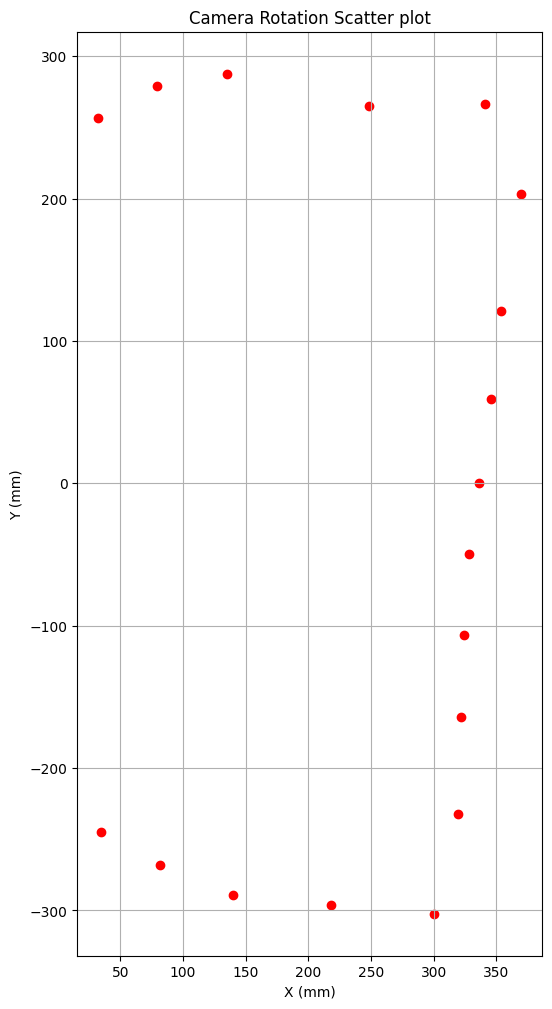

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


angles_rad = np.deg2rad(Raw_data['angle'])
distances = Raw_data['tof']

x = np.zeros(len(Raw_data))
y = np.zeros(len(Raw_data))
u = distances * np.cos(angles_rad)
v = distances * np.sin(angles_rad)
plt.figure(figsize=(6, 12))
plt.scatter(u, v, color='red')


plt.grid()
plt.title('Camera Rotation Scatter plot')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.show()